# New Tables: city level

* Faire les tableaux suivants:
  * Tableau 4: Kuznet: benchmark → Revision
      * Trouver un tableau avec les déciles pour montrer:
        * turning point croissant pour des villes avec une dominance étatique de plus en plus large
      * Regarder si gdp/cap prix constant
      * Indiquer les turning points dans les tableaux
* Partie 6:
  * Tableau 8: 
    * estimer 2 modèles sur des échantillons differents
      * modèle 1 →  TCZ * Polluted * Period
      * modèle 2 → Target * polluted*Period  
    * Echantillonnage → prendre soit industry soit city industry
      * Big
        * Via Herfhindal 
          * benchmark →Revision
      * Foreign 
        * via output/capital/employment 
      * SOEs
        * via output/capital/employment 
      * SPZ
      * Coastal
    * Chaque tableau avec Panel A pour supérieur threshold, Panel B pour inférieur threshold
  * Tableau 9:
    * Enlever SPZ & Coastal
    * estimer 2 modèles sur des échantillons differents
      * modèle 1 →  TCZ * Polluted * Period
      * modèle 2 → Target * polluted*Period  
    * Idem tableau 8

In [2]:
import pandas as pd
from Fast_connectCloud import connector
import numpy as np

In [3]:
import functions.latex_beautify as lb

%load_ext autoreload
%autoreload 2

In [4]:
gs = connector.open_connection(online_connection = False,
                              path_credential = '/Users/thomas/Google Drive/Projects/Client_Oauth/Google_auth')

service = gs.connect_remote('GCP')

Service account storage and Bigquery are now connected. 
Service account storage is stored as <google.cloud.storage.client.Client object at 0xa1bfb6b90> and accessible with "Storage_account" 
Service account Bigquery is stored as <google.cloud.bigquery.client.Client object at 0xa17300e10> and accessible with "bigquery_account"


In [5]:
%put df_final --to R

from GoogleDrivePy.google_platform import connect_cloud_platform
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project, 
                                             service_account = service['GoogleCloudP'])    
query = (
          "SELECT * "
            "FROM China.SBC_pollution_China "

        )

df_final = gcp.upload_data_from_bigquery(query = query, location = 'US')
df_final.head()

,year,Period,Province_en,Lower_location,Larger_location,Coastal,cityen,geocode4_corr,TCZ_c,target_c,effort_c,industry,ind2,Short,output_fcit,capital_fcit,labour_fcit,out_share_SOE,cap_share_SOE,lab_share_SOE,tso2_cit,tso2_i,tCOD_cit,twaste_water_cit,polluted_di,polluted_mi,polluted_thre,FE_c_i,FE_t_i,FE_t_c
0,2002,Before,Shanxi,Central,Central,False,Yuncheng,1408,TCZ,0.485030,Above,3329,33,Smelting Non-ferrous Metals,0.000687,0.000293,0.00036,0.027567,0.221018,0.113467,24500,168934.454545,0.0,500,Above,Below,Above,11104,1573,889
1,2006,After,Hunan,Central,Central,False,Xiangtan,4303,TCZ,0.092754,Below,3329,33,Smelting Non-ferrous Metals,0.000950,0.000148,0.00023,0.027567,0.221018,0.113467,2304,168934.454545,0.0,300,Above,Below,Above,11105,1574,420
2,2007,After,Hunan,Central,Central,False,Xiangtan,4303,TCZ,0.092754,Below,3329,33,Smelting Non-ferrous Metals,0.001715,0.000365,0.00023,0.027567,0.221018,0.113467,2304,168934.454545,0.0,240,Above,Below,Above,11105,1572,421
3,2007,After,Liaoning,Northeast,Eastern,True,Jinzhou,2107,TCZ,0.080512,Below,3329,33,Smelting Non-ferrous Metals,0.007730,0.001296,0.00089,0.027567,0.221018,0.113467,3200,168934.454545,0.0,0,Above,Below,Above,11103,1572,287
4,2002,Before,Liaoning,Northeast,Eastern,True,Shenyang,2101,TCZ,0.230076,Above,3329,33,Smelting Non-ferrous Metals,0.000997,0.000052,0.00135,0.027567,0.221018,0.113467,3840,168934.454545,0.0,3500,Above,Below,Above,11106,1573,432


/Users/thomas/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


In [6]:
options(warn=-1)
library(tidyverse)
library(lfe)
library(lazyeval)
library('progress')

path = "functions/SBC_pollution_R.R"
source(path)
path = "functions/SBC_pollutiuon_golatex.R"
source(path)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lazyeval’


The following objects are masked from ‘package:purrr’:

    is_atomic, is_formula



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [7]:
df_final <- df_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )
head(df_final)

,year,Period,Province_en,Lower_location,Larger_location,Coastal,cityen,geocode4_corr,TCZ_c,target_c,⋯,tso2_cit,tso2_i,tCOD_cit,twaste_water_cit,polluted_di,polluted_mi,polluted_thre,FE_c_i,FE_t_i,FE_t_c
,<dbl>,<fct>,<fct>,<fct>,<fct>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,2002,Before,Shanxi,Central,Central,FALSE,Yuncheng,1408,TCZ,0.48502998,⋯,24500,168934.5,0,500,Above,Below,Above,11104,1573,889
2,2006,After,Hunan,Central,Central,FALSE,Xiangtan,4303,TCZ,0.09275420,⋯,2304,168934.5,0,300,Above,Below,Above,11105,1574,420
3,2007,After,Hunan,Central,Central,FALSE,Xiangtan,4303,TCZ,0.09275420,⋯,2304,168934.5,0,240,Above,Below,Above,11105,1572,421
4,2007,After,Liaoning,Northeast,Eastern,TRUE,Jinzhou,2107,TCZ,0.08051164,⋯,3200,168934.5,0,0,Above,Below,Above,11103,1572,287
5,2002,Before,Liaoning,Northeast,Eastern,TRUE,Shenyang,2101,TCZ,0.23007570,⋯,3840,168934.5,0,3500,Above,Below,Above,11106,1573,432
6,2002,Before,Guangdong,Coastal,Eastern,TRUE,Meizhou,4414,No_TCZ,0.02596999,⋯,72752,168934.5,15500,115000,Above,Below,Above,11107,1573,909


# Partie 6

## Tableau 8 A and B 

Estimate the following models using different subsamples:

### Model A 

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { TCZ }_{i} \times \text { Polluting sectors }_{k} \right)+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
$$

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { TCZ }_{i} \times \text { Polluting sectors }_{k} \times \text{ Share X}_i \right)+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
$$

### Model B

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k}\right)+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
$$

* Size
    * Via Herfhindal 
        * benchmark →Revision
* Foreign 
    * via output/capital/employment 
* SOEs
    * via output/capital/employment 
* SPZ
* Coastal

## Load Data

### Compute Herfhindal: proxy Size

$$
H=\sum_{i=1}^{N} s_{i}^{2}
$$

where $s_i$ is the market share of city $i$ in the industry, and $N$ is the number of firms. 

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by city-industry: `market_share_cit`
- Step 2: compute the sum of squared market share by city: `Herfindahl_ct`
- Step 3: Compute the average across time: `Herfindahl_c`
- Step 4: Compute the deciles of step 3: `decile_herfhindal_c`
    - Low decile implies a low concentration within sectors
    - High decile implies a high concentration within sectors

In [12]:
query = """
WITH sum_cit AS (
  SELECT geocode4_corr, cic, sum(output) as sum_o_cit, year
  FROM China.asif_firm_china 
  WHERE year >= 2002 AND year <= 2007
  GROUP BY geocode4_corr, cic, year
) 
SELECT * 
FROM 
  (WITH sum_ct AS (
    SELECT geocode4_corr, SUM(sum_o_cit) as sum_o_ct, year
    FROM sum_cit
    WHERE year >= 2002 AND year <= 2007
    GROUP BY year, geocode4_corr
)
SELECT *
FROM
  (WITH ms_cit AS (
    SELECT  sum_cit.cic, sum_cit.geocode4_corr, sum_cit.year,
    sum_cit.sum_o_cit/NULLIF(sum_ct.sum_o_ct, 0) as market_share_cit
    FROM sum_cit
    LEFT JOIN sum_ct
ON (
sum_cit.year = sum_ct.year AND 
sum_cit.geocode4_corr = sum_ct.geocode4_corr
)
)
SELECT *
FROM
  (WITH agg_1 AS (
SELECT geocode4_corr, SUM(POW(market_share_cit, 2)) as Herfindahl_ct,
year
FROM ms_cit
GROUP BY year, geocode4_corr
ORDER BY year, geocode4_corr 
)
SELECT *
FROM (
WITH avg_H_c AS (
SELECT geocode4_corr, AVG(Herfindahl_ct) as Herfindahl_c
FROM agg_1
GROUP BY geocode4_corr
)
SELECT geocode4_corr, Herfindahl_c ,
NTILE(10)  OVER (ORDER BY Herfindahl_c) as
decile_herfhindal_c
FROM avg_H_c
ORDER BY decile_herfhindal_c
))))
"""
df_herfhindal = gcp.upload_data_from_bigquery(query = query,
                                         location = 'US')
df_herfhindal['decile_herfhindal_c'].value_counts().sort_index()

1     29
2     29
3     29
4     29
5     28
6     28
7     28
8     28
9     28
10    28
Name: decile_herfhindal_c, dtype: int64

### Compute Ownership: proxy Foreign/SOE

$$\sum output_{co}/ \sum output_c$$

- with $c$ stands for city
- $o$ stands for ownership (Foreign vs Domestic or SOE vs private)



#### Foreign vs domestic

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by city, ownership (Foreign/Domestic): `Share_X_co`
- Step 2: Compute dummy when share Foreign above share domestic by city


In [9]:
query_share_foreign = """ 
WITH sum_co AS (
  SELECT 
    case WHEN ownership = 'Foreign' THEN 'FOREIGN' ELSE 'DOMESTIC' END AS OWNERSHIP, 
    SUM(output / 10000000) as output_co, 
    SUM(fa_net / 10000000) as fa_net_co, 
    SUM(employment / 100000) as employment_co,
    geocode4_corr
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY 
    OWNERSHIP, 
    geocode4_corr
) 
SELECT 
  * 
FROM 
  (
    WITH sum_c AS(
      SELECT 
        SUM(output_co) as output_c, 
        SUM(fa_net_co) as fa_net_c, 
        SUM(employment_co) as employment_c, 
        geocode4_corr AS geocode4_corr_b
      FROM 
        sum_co 
      GROUP BY 
        geocode4_corr
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH share_co AS(
          SELECT 
            OWNERSHIP, 
            output_co / output_c AS share_output_co, 
            fa_net_co / fa_net_c AS share_fa_net_co, 
            employment_co / employment_c AS share_employement_co, 
            geocode4_corr
          FROM 
            sum_co 
            LEFT JOIN sum_c ON sum_co.geocode4_corr = sum_c.geocode4_corr_b 
        ) 
        SELECT 
        * 
        FROM(
        WITH decile_c AS (
        SELECT 
        geocode4_corr,
        OWNERSHIP,  
        NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_output_co) 
          as rank_share_output_c,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_fa_net_co) 
          as rank_share_capital_c,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_employement_co) 
          as rank_share_employement_c,
          share_output_co,
          share_fa_net_co,
          share_employement_co
        FROM share_co
        )
        SELECT * 
        FROM decile_c 
        /*WHERE OWNERSHIP = 'FOREIGN'*/
        )
        )
        )
"""
df_share_foreign = gcp.upload_data_from_bigquery(query = query_share_foreign,
                                         location = 'US')
df_share_foreign['rank_share_output_c'].value_counts().sort_index()

1     57
2     57
3     57
4     57
5     56
6     55
7     55
8     55
9     55
10    55
Name: rank_share_output_c, dtype: int64

In [11]:
df_share_foreign = (df_share_foreign
 .set_index(['geocode4_corr', 'OWNERSHIP'])
 .drop(columns = ['rank_share_output_c',
                  'rank_share_capital_c',
                  'rank_share_employement_c'])
 .unstack(-1)
 .fillna(0)
 .assign(
 output = lambda x: np.where(
     x.iloc[:,1] > x.iloc[:,0],
     'Above', 'Below'
 ),
     capital = lambda x: np.where(
     x.iloc[:,3] > x.iloc[:,0],
     'Above', 'Below'
 ),
     employment = lambda x: np.where(
     x.iloc[:,5] > x.iloc[:,0],
     'Above', 'Below'
 )
 )
 .iloc[:, -3:]
 .droplevel(level = 1, axis = 1)
 .reset_index()
)
for i in ['output','capital', 'employment']:
    print(df_share_foreign[i].value_counts().sort_index())

Above      7
Below    277
Name: output, dtype: int64
Above      5
Below    279
Name: capital, dtype: int64
Above      7
Below    277
Name: employment, dtype: int64


#### SOE

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by city, ownership (SOE/Private): `Share_X_co`
- Step 2: Compute dummy when share SOE above share Private by city

In [13]:
query_share_soe = """ 
WITH sum_co AS (
  SELECT 
    case WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS OWNERSHIP, 
    SUM(output / 10000000) as output_co, 
    SUM(fa_net / 10000000) as fa_net_co, 
    SUM(employment / 100000) as employment_co,
    geocode4_corr
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY 
    OWNERSHIP, 
    geocode4_corr
) 
SELECT 
  * 
FROM 
  (
    WITH sum_c AS(
      SELECT 
        SUM(output_co) as output_c, 
        SUM(fa_net_co) as fa_net_c, 
        SUM(employment_co) as employment_c, 
        geocode4_corr AS geocode4_corr_b
      FROM 
        sum_co 
      GROUP BY 
        geocode4_corr
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH share_co AS(
          SELECT 
            OWNERSHIP, 
            output_co / output_c AS share_output_co, 
            fa_net_co / fa_net_c AS share_fa_net_co, 
            employment_co / employment_c AS share_employement_co, 
            geocode4_corr
          FROM 
            sum_co 
            LEFT JOIN sum_c ON sum_co.geocode4_corr = sum_c.geocode4_corr_b 
        ) 
        SELECT 
        * 
        FROM(
        WITH decile_c AS (
        SELECT 
        geocode4_corr,
        OWNERSHIP,  
        NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_output_co) 
          as rank_share_output_c,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_fa_net_co) 
          as rank_share_capital_c,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_employement_co) 
          as rank_share_employement_c,
          share_output_co,
          share_fa_net_co,
          share_employement_co
        FROM share_co
        )
        SELECT * 
        FROM decile_c 
        /*WHERE OWNERSHIP = 'FOREIGN'*/
        )
        )
        )
"""
df_share_soe = gcp.upload_data_from_bigquery(query = query_share_soe,
                                         location = 'US')
df_share_soe['rank_share_output_c'].value_counts().sort_index()

1     58
2     58
3     58
4     58
5     56
6     56
7     56
8     56
9     56
10    56
Name: rank_share_output_c, dtype: int64

In [14]:
df_share_soe = (df_share_soe
 .set_index(['geocode4_corr', 'OWNERSHIP'])
 .drop(columns = ['rank_share_output_c',
                  'rank_share_capital_c',
                  'rank_share_employement_c'])
 .unstack(-1)
 .fillna(0)
 .assign(
 output = lambda x: np.where(
     x.iloc[:,1] > x.iloc[:,0],
     'Above', 'Below'
 ),
     capital = lambda x: np.where(
     x.iloc[:,3] > x.iloc[:,0],
     'Above', 'Below'
 ),
     employment = lambda x: np.where(
     x.iloc[:,5] > x.iloc[:,0],
     'Above', 'Below'
 )
 )
 .iloc[:, -3:]
 .droplevel(level = 1, axis = 1)
 .reset_index()
)

for i in ['output','capital', 'employment']:
    print(df_share_soe[i].value_counts().sort_index())

Above     41
Below    243
Name: output, dtype: int64
Above     57
Below    227
Name: capital, dtype: int64
Above     39
Below    245
Name: employment, dtype: int64


### Add to table

In [15]:
%put df_herfhindal_final --to R
df_herfhindal_final = df_final.merge(df_herfhindal,
                                     on=['geocode4_corr'],
                                     how='left',
                                     indicator=True
                                     )

INFO: NumExpr defaulting to 8 threads.

In [16]:
df_herfhindal_r <- df_herfhindal_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [23]:
%put df_final_SOE --to R
df_final_SOE = (df_final.merge(
    df_share_soe,
    how = 'left',
    indicator = True
)
                #.assign(
                #    rank_share_output_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_capital_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_employement_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #)
)
for i in ['output', 'capital', 'employment']:
    print(df_final_SOE[i].value_counts())

Below    27613
Above     3063
Name: output, dtype: int64
Below    25705
Above     4971
Name: capital, dtype: int64
Below    27140
Above     3536
Name: employment, dtype: int64


In [24]:
df_final_SOE <- df_final_SOE %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [25]:
%put df_final_FOREIGN --to R
df_final_FOREIGN = (df_final.merge(
    df_share_foreign,
    how = 'left',
    on = ['geocode4_corr'],
    indicator = True
)
                #.assign(
                #    rank_share_output_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_capital_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_employement_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #)

)
for i in ['output', 'capital', 'employment']:
    print(df_final_FOREIGN[i].value_counts())

Below    30228
Above      448
Name: output, dtype: int64
Below    30478
Above      198
Name: capital, dtype: int64
Below    30238
Above      438
Name: employment, dtype: int64


In [26]:
df_final_FOREIGN <- df_final_FOREIGN %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

## Table 8 Model A: Panel A



### Test Size

In [27]:
#### Output
l <- list()
l1 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_c < i),
             exactDOF=TRUE)
    
    t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_c < i),
             exactDOF=TRUE)
    
    l[[i - 2]] <- t1
    l1[[i-2]] <- t2
}

#### Capital
l2 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_c < i),
             exactDOF=TRUE)

    l2[[i - 2]] <- t1
}

#### Employment
l3 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_c < i),
             exactDOF=TRUE)
    
    l3[[i - 2]] <- t1
}

file.remove("table_1.txt")
file.remove("table_1.tex")
file.remove("table_2.txt")
file.remove("table_2.tex")
file.remove("table_3.txt")
file.remove("table_3.tex")
file.remove("table_4.txt")
file.remove("table_4.tex")

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(l,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_1.txt"
)

table_1 <- go_latex(l1,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_2.txt"
)

table_1 <- go_latex(l2,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Capital: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_3.txt"
)
table_1 <- go_latex(l3,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Employement: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_4.txt"
)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

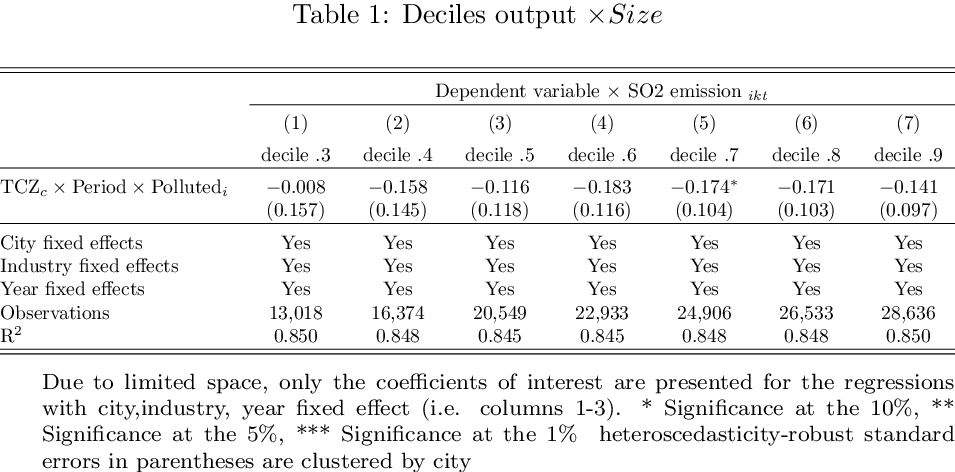

In [28]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

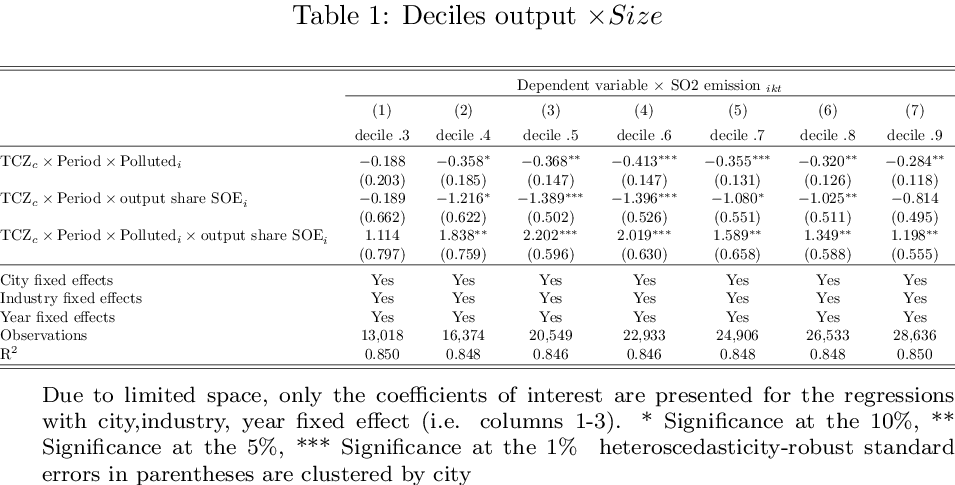

In [29]:
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True, 
           resolution = 200)

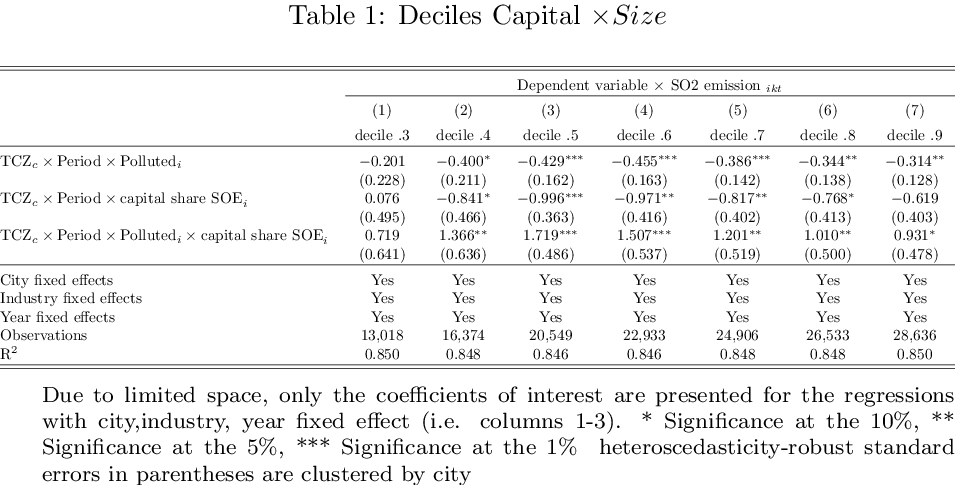

In [30]:
lb.beautify(table_number = 3,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True, 
           resolution = 200)

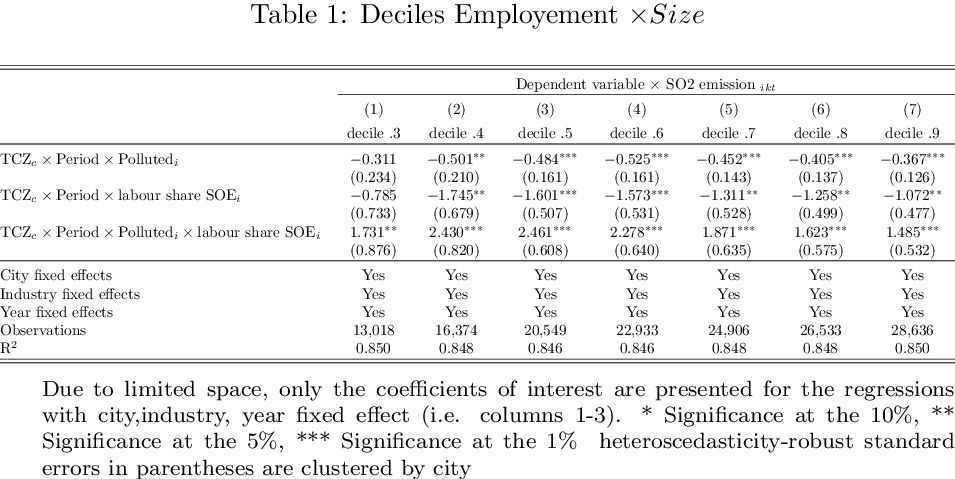

In [31]:
lb.beautify(table_number = 4,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True, 
           resolution = 200)

#### Foreign: Not applicable

Not enough observation, or say differently, no sectors are dominated by Foreign firms solenly

#### SOE

Reminder, in the table below, we include sectors solenly dominated by SOE -> Share output/cap/emp of SOE stricly superior with Private

In [32]:
##### Panel A
## Output
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Above'),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Above'),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Above'),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Above'),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Above'),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Above'),
             exactDOF=TRUE)
la <- list(t1, t2, t3, t4, t5, t6)
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### Panel B
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Below'),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Below'),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Below'),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Below'),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Below'),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Below'),
             exactDOF=TRUE)
lb <- list(t1, t2, t3, t4, t5, t6)

file.remove("table_5.txt")
file.remove("table_5.tex")
file.remove("table_6.txt")
file.remove("table_6.tex")
fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(la,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel A: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_5.txt"
)
table_1 <- go_latex(lb,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel B: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_6.txt"
)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

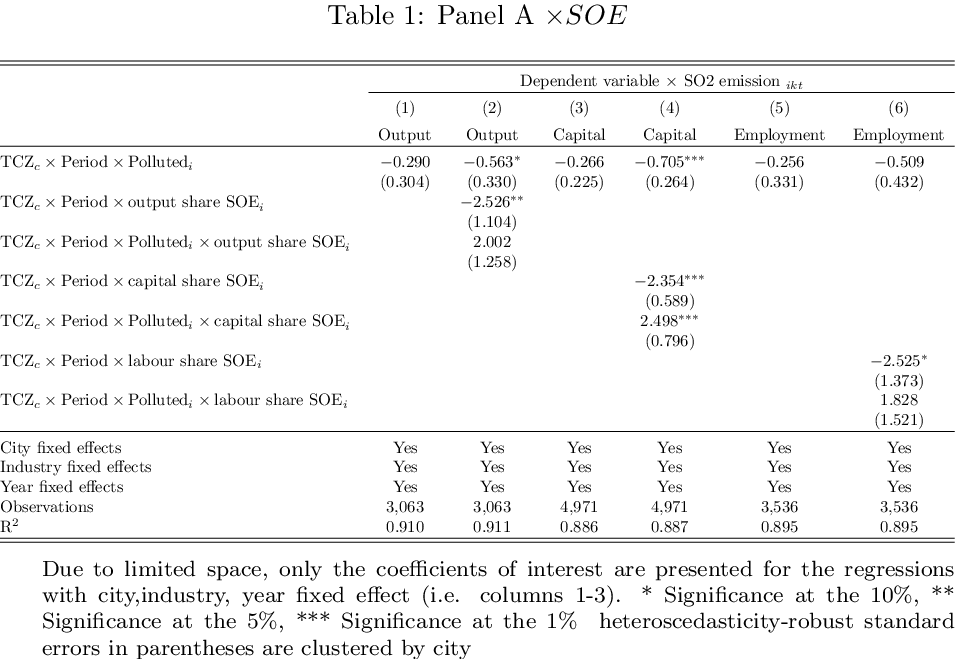

In [33]:
import os
decile=['& Output','Output',
        'Capital', 'Capital',
       'Employment','Employment']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 5,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
           resolution = 200)

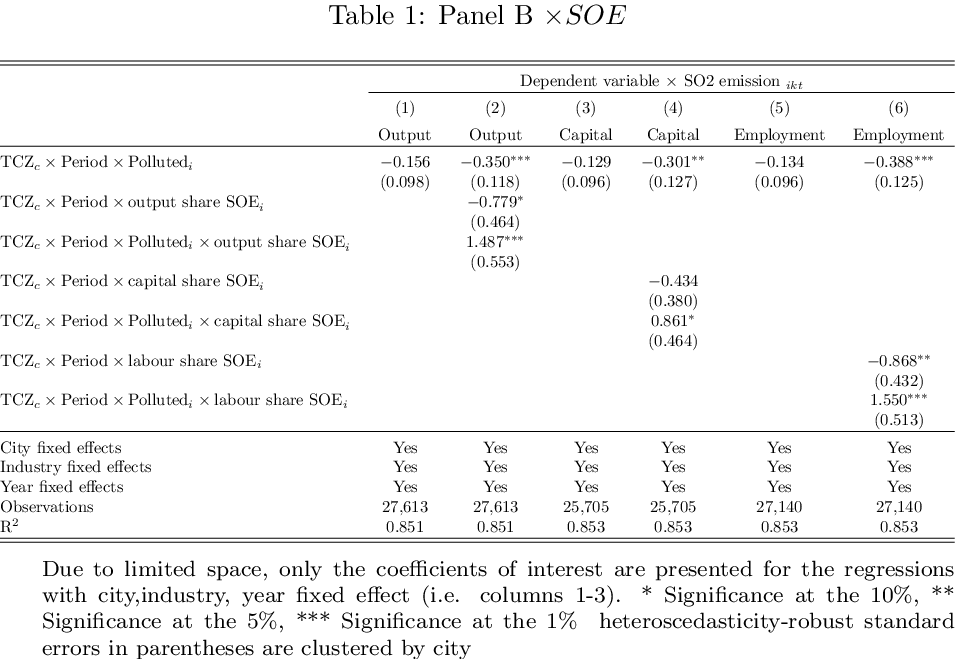

In [34]:
lb.beautify(table_number = 6,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
            resolution = 200)